In [23]:
# Imports
import time
import math
import sys
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
from PIL import Image
from scipy import ndimage
from utils import *
from model import cnn_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# train_data_orig, train_labels_orig, eval_data_orig, eval_labels_orig, classes = load_dataset()
# classes = 6
# train_labels = np.squeeze(train_labels_orig)
# train_labels_old = train_labels
# train_labels = one_hot_label(classes, train_labels_old)
# eval_labels = np.squeeze(eval_labels_orig)
# eval_labels_old = eval_labels
# eval_labels = one_hot_label(classes, eval_labels_old)
# # Flatten the training and test images
# train_data = train_data_orig.reshape(train_data_orig.shape[0], -1).T
# eval_data = eval_data_orig.reshape(eval_data_orig.shape[0], -1).T
# # Normalize image vectors
# train_data = train_data/255.
# eval_data = eval_data/255.
# features = train_data.shape[0]
# print(train_data.shape)

In [25]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
classes = 10
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
train_labels = one_hot_label(classes, train_labels)
eval_data = mnist.test.images # Returns np.array
eval_labels_old = np.asarray(mnist.test.labels, dtype=np.int32)
eval_labels = one_hot_label(classes, eval_labels_old)
features = train_data.shape[0]

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


## Plan
**input layer:** mx28x28x1

**conv layer1 + Relu:** mx28x28x32

**pool layer1:** mx14x14x32

**conv layer2 + Relu:** mx14x14x64

**pool layer2:** mx7x7x64

**flatten:** mx3136

**fc layer1:** mx1024

**output layer:** mx10

**softmax:** mx10

Cost after iteration 0, batch 0: 2.319218
Cost after iteration 0, batch 1: 2.267973
Cost after iteration 0, batch 2: 2.385270
Cost after iteration 0, batch 3: 1.892367
Cost after iteration 0, batch 4: 1.932213
Cost after iteration 0, batch 5: 1.981529
Cost after iteration 0, batch 6: 1.932300
Cost after iteration 0, batch 7: 1.960672
Epoch 0, Done!
Cost after iteration 1, batch 0: 1.617976
Cost after iteration 1, batch 1: 1.556755
Cost after iteration 1, batch 2: 1.673309
Cost after iteration 1, batch 3: 1.275882
Cost after iteration 1, batch 4: 1.337077
Cost after iteration 1, batch 5: 1.368439
Cost after iteration 1, batch 6: 1.416648
Cost after iteration 1, batch 7: 1.354134
Epoch 1, Done!
Cost after iteration 2, batch 0: 1.106426
Cost after iteration 2, batch 1: 1.141215
Cost after iteration 2, batch 2: 1.269192
Cost after iteration 2, batch 3: 0.918140
Cost after iteration 2, batch 4: 1.019509
Cost after iteration 2, batch 5: 1.026334
Cost after iteration 2, batch 6: 1.110226
Cost

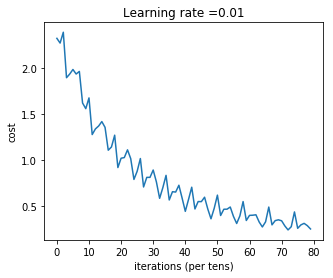

In [26]:
# Input Layer
input_layer = train_data.reshape(55000,1,28,28)
eval_data = eval_data.reshape(10000,1,28,28)
# training model
filter_dims = [(32,1,5,5),(64,32,5,5)]
layers_dims = [3136, 1024, classes] #  2-layer model
parameters, parameters_conv, grads, conv_grads = cnn_model(input_layer[0:256], train_labels[0:256], filter_dims, layers_dims, 
                                                           truncate = 0, batch_size = 32, learning_rate = 0.01, num_iterations = 10, print_cost = True)


In [21]:
#further training on the same model 
parameters, parameters_conv, grads, conv_grads = cnn_model(input_layer[0:256], train_labels[:,0:256], layers_dims, filter_dims, 
                                                           truncate = 4, batch_size = 32, learning_rate = 0.01, num_iterations = 5, parameters = parameters, parameters_conv = parameters_conv, print_cost = True)


Cost after iteration 0, batch 0: 1.431098
Cost after iteration 0, batch 1: 1.670107
Cost after iteration 0, batch 2: 1.553089
Cost after iteration 0, batch 3: 1.409872
Cost after iteration 0, batch 4: 1.420728
Cost after iteration 0, batch 5: 1.464039
Cost after iteration 0, batch 6: 1.583235
Cost after iteration 0, batch 7: 1.477887
Epoch 0, Done!
Cost after iteration 1, batch 0: 1.424538
Cost after iteration 1, batch 1: 1.672094
Cost after iteration 1, batch 2: 1.551366
Cost after iteration 1, batch 3: 1.402603
Cost after iteration 1, batch 4: 1.416983


KeyboardInterrupt: 

In [265]:
from layers.quantize import truncate_weights
q = 2
parameters['W1'] = truncate_weights(parameters['W1'], q, weights_range = 0.08)
parameters['b1'] = truncate_weights(parameters['b1'], q, weights_range = 0.08)
parameters['W2'] = truncate_weights(parameters['W2'], q, weights_range = 0.08)
parameters['b2'] = truncate_weights(parameters['b2'], q, weights_range = 0.08)
parameters_conv['W1'] = truncate_weights(parameters_conv['W1'], q)
parameters_conv['b1'] = truncate_weights(parameters_conv['b1'], q)
parameters_conv['W3'] = truncate_weights(parameters_conv['W3'], q)
parameters_conv['b3'] = truncate_weights(parameters_conv['b3'], q)

In [8]:
eval_cnn_model(input_layer[0:256], train_labels[:,0:256], parameters, parameters_conv)

#eval_cnn_model(eval_data[0:256], eval_labels[:,0:256], parameters, parameters_conv)

Accuracy: 0.76953125


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [221]:
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
image_num = 88
predict_cnn(eval_data[image_num:image_num+1],parameters, parameters_conv)
print("actual value: " + str(eval_labels_old[image_num]))
data = mnist.test.images[image_num].reshape(28,28)
plt.imshow(data)

In [ ]:
out = np.concatenate((parameters_conv['W1'].reshape(-1),parameters_conv['b1'].reshape(-1), 
                     parameters_conv['W3'].reshape(-1), parameters_conv['b3'].reshape(-1)))
mu = np.mean(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 4 * sigma , mu + 4 * sigma , 1000)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()
print("one std is",sigma)

In [ ]:
out_m = np.concatenate((parameters_conv['W1'].reshape(-1),parameters_conv['b1'].reshape(-1), 
                     parameters_conv['W3'].reshape(-1), parameters_conv['b3'].reshape(-1)))
mu_m = np.mean(out_m)
variance_m = np.var(out_m)
sigma_m = math.sqrt(variance_m)
x_m = np.linspace(mu_m - 4 * sigma_m , mu_m + 4 * sigma_m , 1000)
plt.plot(y,mlab.normpdf(x_m, mu_m, sigma_m),'-', x, mlab.normpdf(x, mu, sigma), '--')
plt.show()
print("one std is",sigma_m)

In [ ]:
out = np.concatenate((conv_grads['dW1'].reshape(-1),conv_grads['db1'].reshape(-1), 
                     conv_grads['dW3'].reshape(-1), conv_grads['db3'].reshape(-1)))
mu = np.mean(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 4 * sigma , mu + 4 * sigma , 1000)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()
print("one std is",sigma)

In [ ]:
out_m = np.concatenate((conv_grads['dW1'].reshape(-1),conv_grads['db1'].reshape(-1), 
                     conv_grads['dW3'].reshape(-1), conv_grads['db3'].reshape(-1)))
mu_m = np.mean(out_m)
variance_m = np.var(out_m)
sigma_m = math.sqrt(variance_m)
x_m = np.linspace(mu_m - 4 * sigma_m , mu_m + 4 * sigma_m , 1000)
plt.plot(x_m,mlab.normpdf(x_m, mu_m, sigma_m),'-', x, mlab.normpdf(x, mu, sigma), '--')
plt.show()
print("one std is",sigma_m)

In [ ]:
out_f = np.concatenate((conv_grads['dW1'].reshape(-1),conv_grads['db1'].reshape(-1), 
                     conv_grads['dW3'].reshape(-1), conv_grads['db3'].reshape(-1)))
mu_f = np.mean(out_f)
variance_f = np.var(out_f)
sigma_f = math.sqrt(variance_f)
x_f = np.linspace(mu_f - 4 * sigma_f , mu_f + 4 * sigma_f , 1000)
plt.plot(x_f,mlab.normpdf(x_f, mu_f, sigma_f),'-',x_m,mlab.normpdf(x_m, mu_m, sigma_m),'-.', x, mlab.normpdf(x, mu, sigma), '--')
plt.show()
print("one std is",sigma_f)

In [ ]:
t = np.arange(0., 5., 0.2)

# red dashes, blue squares and green triangles
plt.plot(t, t, 'r--', t, t**2, 'bs', t, t**3, 'g^', t, t**4, 'r-')
plt.show()

In [ ]:
out = np.concatenate((parameters_conv['W1'].reshape(-1),parameters_conv['W3'].reshape(-1),
                      parameters_conv['b1'].reshape(-1),parameters_conv['b3'].reshape(-1),
                      conv_grads['dW1'].reshape(-1), conv_grads['dW3'].reshape(-1),
                      conv_grads['db1'].reshape(-1),conv_grads['db3'].reshape(-1)))
out = out.reshape(-1,8)
np.savetxt("parameters.csv", out, delimiter=",")

/Users/samshen/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


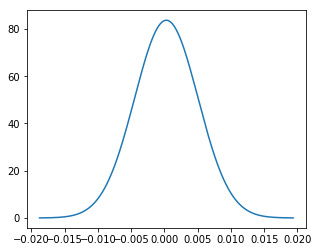

one std is 0.004766489111266608


In [179]:
out = np.concatenate((grads['dW1'].reshape(-1), grads['db1'].reshape(-1), 
                     grads['dW2'].reshape(-1), grads['db2'].reshape(-1)))
mu = np.mean(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 4 * sigma , mu + 4 * sigma , 1000)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()
print("one std is",sigma)

/Users/samshen/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


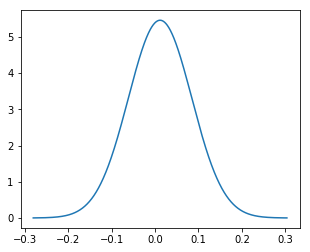

one std is 0.07304826983755976


In [181]:
out = np.concatenate((conv_grads['dW1'].reshape(-1), conv_grads['db1'].reshape(-1), 
                     conv_grads['dW3'].reshape(-1), conv_grads['db3'].reshape(-1)))
mu = np.mean(out)
variance = np.var(out)
sigma = math.sqrt(variance)
x = np.linspace(mu - 4 * sigma , mu + 4 * sigma , 1000)
plt.plot(x,mlab.normpdf(x, mu, sigma))
plt.show()
print("one std is",sigma)

In [218]:
np.ceil(np.array([0.5])).astype(np.int8)

array([1], dtype=int8)